# Predicting bike usage

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

# Feature selection using Recursive Feature Elimimation
from sklearn.feature_selection import RFE

# Sklearn regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Sklearn regression model evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

Define some useful functions

In [17]:
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", r2_score(y, predictions))     
    
def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns    


def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 2
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model

## Load and understand the data

In [3]:
dataset = pd.read_csv('C:/Users/MyPC/MyPython/Project/Files/Evaluate-Improve-Models-master/bike.csv')
dataset.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [4]:
dataset.dtypes

id                            int64
season                       object
year                          int64
holiday                       int64
weekday                       int64
workingday                    int64
weather                      object
temp                        float64
feel_temp                   float64
hum                         float64
windspeed                   float64
promotion_level               int64
promotion_type                int64
promotion_level_external      int64
promotion_type_external       int64
casual                        int64
registered                    int64
cnt                           int64
dtype: object

In [5]:
dataset.isnull().mean()

id                          0.0
season                      0.0
year                        0.0
holiday                     0.0
weekday                     0.0
workingday                  0.0
weather                     0.0
temp                        0.0
feel_temp                   0.0
hum                         0.0
windspeed                   0.0
promotion_level             0.0
promotion_type              0.0
promotion_level_external    0.0
promotion_type_external     0.0
casual                      0.0
registered                  0.0
cnt                         0.0
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 2016.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


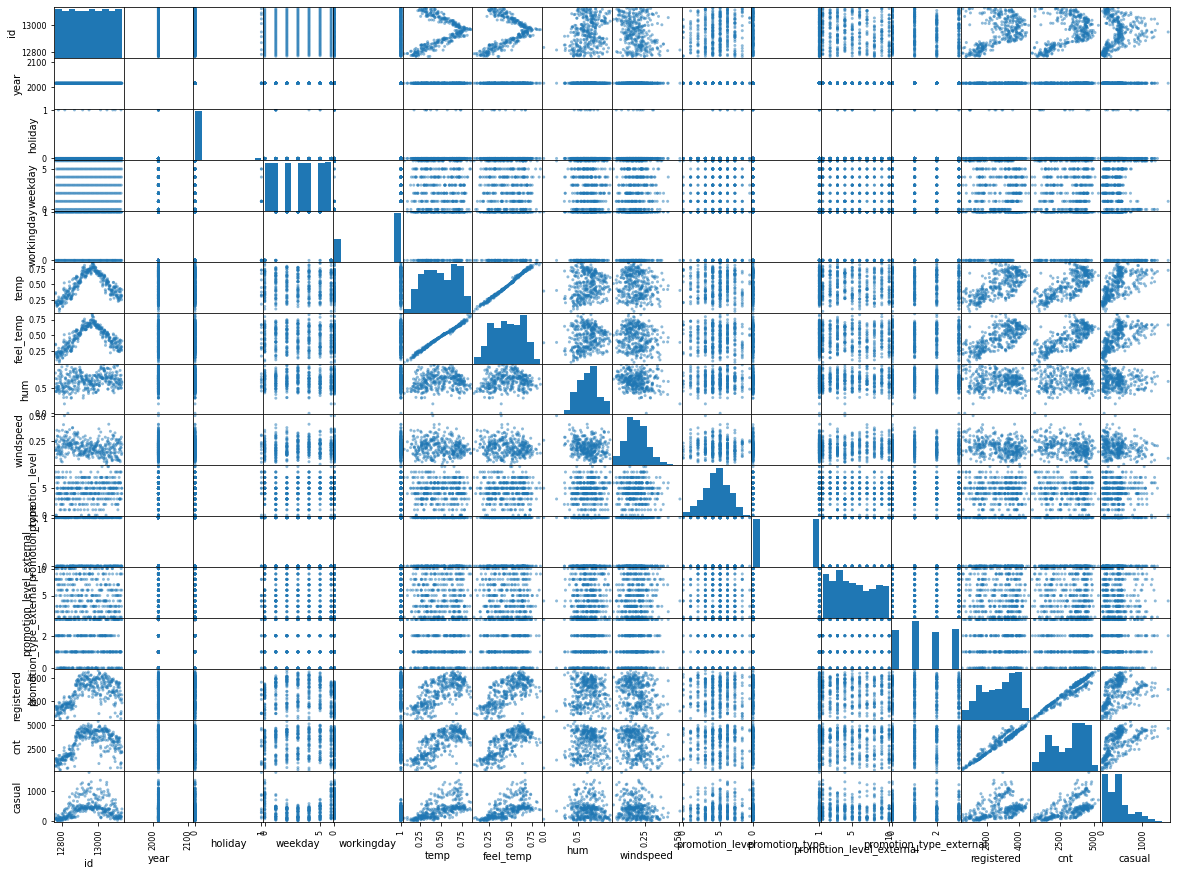

In [8]:
# Plot a scatter matrix
# I like to push the target feature to the bottom, so it is easy to read
df = dataset.drop('casual',axis=1).join(dataset.casual)
pd.plotting.scatter_matrix(df,figsize=(20,15))
plt.show()

**Correlations to our target**

Looking at the scatter plot above, we see good correlations to our target feature from temp, feel_temp, registered, cnt. Holiday and weekday also seem to have some relationship.

**Multicollinearity**

The two temperature columns, temp and feel_temp are unsurprisingly highly correlated. We will probably want to remove one.

Also cnt and registered seem to be correlated. This is unsurprising, as cnt is the total of casual + registered. In fact, we should remove BOTH cnt and registered as they will cause "data leakage". Both columns can only be known if we know the number of bike hires on a particular day, which is what we are trying to predict! They are, effectively, "inside information" which we can't really know in a real-life prediction situation.

## Feature engineering

Remove the data leakage features

In [9]:
# Drop cnt and registered as they will cause data leakage
dataset = dataset.drop(['cnt', 'registered'], axis=1)

dataset = dataset.drop(['id'], axis=1)
dataset.head()

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual
0,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226
1,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125
2,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75
3,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67
4,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58


We have a few categorical columns, so we one-hot-encode these to convert them into numerical columns.

In [12]:
categoricals = ['season', 'weekday', 'weather']
dataset = pd.get_dummies(dataset, columns=categoricals)
dataset.head()

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cloud,weather_fair,weather_rain
0,2016,0,0,0.344167,0.363625,0.805833,0.160446,7,1,2,...,0,0,0,0,0,0,1,1,0,0
1,2016,0,0,0.363478,0.353739,0.696087,0.248539,8,1,8,...,1,0,0,0,0,0,0,1,0,0
2,2016,0,1,0.196364,0.189405,0.437273,0.248309,3,1,10,...,0,1,0,0,0,0,0,0,1,0
3,2016,0,1,0.200000,0.212122,0.590435,0.160296,0,1,8,...,0,0,1,0,0,0,0,0,1,0
4,2016,0,1,0.226957,0.229270,0.436957,0.186900,2,0,5,...,0,0,0,1,0,0,0,0,1,0


### Split into X and y

In [13]:
X = dataset.drop(['casual'],axis=1)
y = dataset.casual

### Rescale

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_,columns=X.columns)

## Simple linear regression

Build a linear regression model as a baseline, so we can see the effect of any improvement we make later.

In [15]:
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

Train set:
    R2 0.798265855369959
Test set:
    R2 0.7444590452036944


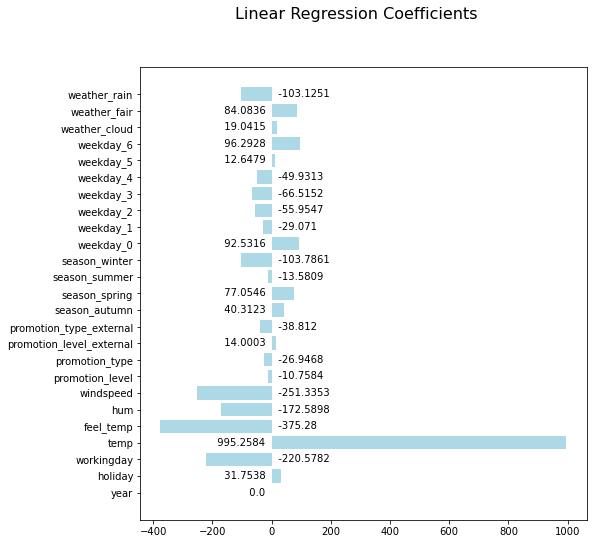

In [18]:
# Build and evaluate a linear regression model

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)
print("Train set:")
score(model, X_train, y_train)

# Evaluate
print("Test set:")
score(model, X_test, y_test)

# Summary
linearRegressionSummary(model, X_train.columns)

## Resampling with k-fold cross-validation

Evaluate linear regression with 10-fold cross validation

LinearRegression
kFoldCV:
    Fold R2 scores: [0.70089783 0.75747131 0.7560967  0.59646467 0.81138158 0.76843462
 0.84251758 0.74793549 0.762693   0.7103859 ]
    Mean R2 score: 0.74542786899212
    Std R2 score: 0.063458453678237
Test set
    R2 0.7444590452036944


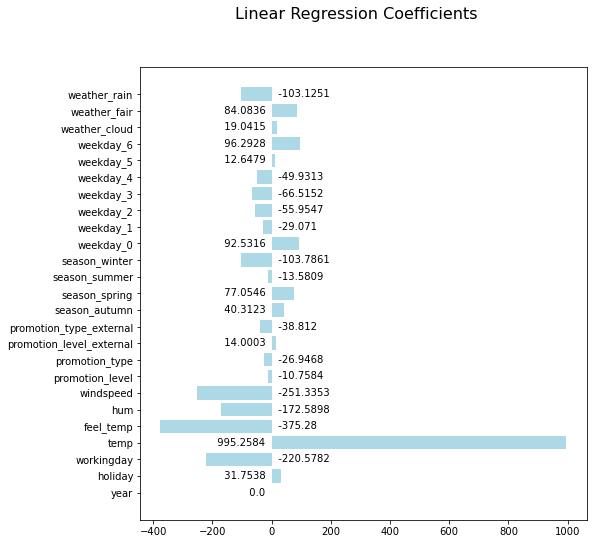

In [19]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X_train, y_train)

# I will evaluate using the test set
print("Test set")
score(model, X_test, y_test)

linearRegressionSummary(model, X_train.columns)


The R-squared scores are pretty consistent. We can be more confident in it due to the evaluation against 10 folds.

## Feature selection

### Remove low variance features

Identify some low variance features, those with variance less than 0.1 and remove them.

In [20]:
# Check the shape before we remove anything
X_test.shape

(121, 25)

In [21]:
X.var()

year                        0.000000
holiday                     0.026720
workingday                  0.216393
temp                        0.057592
feel_temp                   0.049115
hum                         0.023394
windspeed                   0.025126
promotion_level             0.044400
promotion_type              0.250685
promotion_level_external    0.104256
promotion_type_external     0.134599
season_autumn               0.187671
season_spring               0.189041
season_summer               0.189041
season_winter               0.186286
weekday_0                   0.122505
weekday_1                   0.122505
weekday_2                   0.122505
weekday_3                   0.122505
weekday_4                   0.122505
weekday_5                   0.122505
weekday_6                   0.124462
weather_cloud               0.224928
weather_fair                0.236444
weather_rain                0.039515
dtype: float64

Try removing low variance features using VarianceThreshold

In [22]:
sel = VarianceThreshold(threshold=(0.01))
sel.fit(X_train)

selected_features = list(X_train.columns[sel.get_support()])
print("Feature selection", sel.get_support())
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~sel.get_support()]))

Feature selection [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
Selected features: ['holiday', 'workingday', 'temp', 'feel_temp', 'hum', 'windspeed', 'promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'season_autumn', 'season_spring', 'season_summer', 'season_winter', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weather_cloud', 'weather_fair', 'weather_rain']
Removed features: ['year']


In [23]:
# Transform (remove low variance features)
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [24]:
# Turn back into a dataframe
X_train = pd.DataFrame(X_train, columns=selected_features)
X_test = pd.DataFrame(X_test, columns=selected_features)

In [25]:
# Confirm the new shape
X_train.shape

(244, 24)

### Correlated features
Remove highly correlated features

In [26]:
# Get a set of correlated features, based on threshold correlation of 0.85
cf = correlatedFeatures(X_train, 0.85)
cf

{'feel_temp', 'weather_fair'}

In [27]:
# Remove the correlated features
X_train = X_train.drop(cf, axis=1)
X_test = X_test.drop(cf, axis=1)

In [28]:
# Confirm the new shape
X_train.shape

(244, 22)

## Apply RFE
Systematically determine number of features to keep

In [30]:
# Build models using from 1 to n-1 features
for i in range(1,X_train.shape[1]-1):
    print("\nRFE ", i, end="\t")
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    rfe = RFE(model, i)
    rfe.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Evaluate using k-fold cross-validation
    model = kFoldCV(X_train_rfe, y_train, silent=True)
    predictions = model.predict(X_test_rfe)
    print("R2", r2_score(y_test, predictions))


RFE  1	R2 0.3246281329358406

RFE  2	R2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


 0.7051208652825429

RFE  3	R2 0.7044749355460929

RFE  4	R2 0.7266852555551557

RFE  5	

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


R2 0.7416662131598455

RFE  6	R2 0.7411372476279006

RFE  7	R2 0.7406398592660238

RFE  8	R2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


 0.7433543727611176

RFE  9	R2 0.7425425287943135

RFE  10	R2 0.7440307466805103

RFE  11	

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=11 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


R2 0.7496281317033937

RFE  12	R2 0.7517049221297419

RFE  13	R2 0.7530614286111912

RFE  14	

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=13 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


R2 0.7573658737365601

RFE  15	R2 0.7573658737365603

RFE  16	R2 0.7567320347002514

RFE  17	R2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=16 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=17 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


 0.7552648268976772

RFE  18	R2 0.7431786086989423

RFE  19	R2 0.742669516800103

RFE  20	R2 0.7426695168001027


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=19 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


The best R-squared is with 15 features. So let's keep just 15

In [31]:
# Create a model
model = LinearRegression()

# Select the best features according to RFE
rfe = RFE(model, 15)
rfe.fit(X_train, y_train)

selected_features = list(X_train.columns[rfe.support_])
print("Feature selection", rfe.support_)
print("Feature ranking", rfe.ranking_)
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~rfe.support_]))

Feature selection [ True  True  True  True  True False False False False  True  True False
  True  True False  True  True  True False  True  True  True]
Feature ranking [1 1 1 1 1 8 4 5 3 1 1 7 1 1 2 1 1 1 6 1 1 1]
Selected features: ['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_autumn', 'season_spring', 'season_winter', 'weekday_0', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_6', 'weather_cloud', 'weather_rain']
Removed features: ['promotion_level', 'promotion_type', 'promotion_level_external', 'promotion_type_external', 'season_summer', 'weekday_1', 'weekday_5']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [32]:
# Transform (remove features not selected)
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

## Evaluate a model with the features removed
Now that we have removed a number of features using low-variance removal, highly correlated feature removal and RFE, build and evaluate a linear regression model with this reduced feature set.

LinearRegression
kFoldCV:
    Fold R2 scores: [0.78061576 0.74877529 0.7520322  0.58639477 0.82789427 0.76167203
 0.82921395 0.75347647 0.7704151  0.75519491]
    Mean R2 score: 0.756568474364127
    Std R2 score: 0.06341343083081286
Test set:
    R2 0.7573658737365603


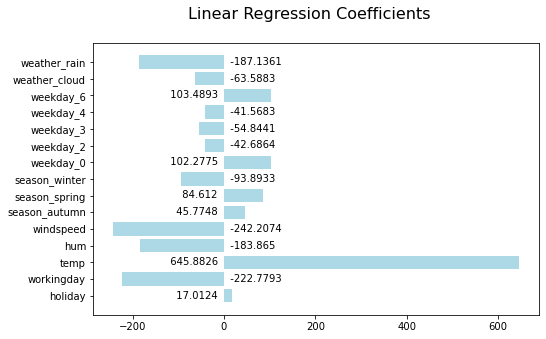

In [33]:
# Build and evaluate a linear regression model with the reduced feature set
model = kFoldCV(X_train, y_train)
print("Test set:")
score(model, X_test, y_test)
linearRegressionSummary(model, selected_features)

So, we've managed to improve the R-squared score and removed a number of features, making the model faster and easier to interpret. We've also used cross-validation to give us confidence that the model will perform consistently.